# Happiness in Marriage Analysis

Author: Ashley Swanson

This notebook explores the Happiness in Marriage varriable in the GSS (General Social Survey) conducted by NORC at the University of Chicago. The exploration seeks to find trends realting to time, age, and cohort. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from thinkstats2 import Pmf, Cdf, Hist
from scipy.stats import linregress


import thinkplot

# Loading Data

In [2]:
def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = utils.read_stata_dict(dirname + '/GSS.dct')
    gss = dct.read_fixed_width(dirname + '/GSS.dat.gz',
                             compression='gzip')
    return gss

In [3]:
gss = read_gss('gss_eda')
print(gss.shape)
gss.head()

(62466, 101)


,year,id_,agewed,divorce,sibs,childs,age,educ,paeduc,maeduc,...,memchurh,realinc,cohort,marcohrt,ballot,wtssall,adults,compuse,databank,wtssnr
0,1972,1,0,0,3,0,23,16,10,97,...,0,18951.0,1949,0,0,0.4446,1,0,0,1.0
1,1972,2,21,2,4,5,70,10,8,8,...,0,24366.0,1902,1923,0,0.8893,2,0,0,1.0
2,1972,3,20,2,5,4,48,12,8,8,...,0,24366.0,1924,1944,0,0.8893,2,0,0,1.0
3,1972,4,24,2,5,0,27,17,16,12,...,0,30458.0,1945,1969,0,0.8893,2,0,0,1.0
4,1972,5,22,2,2,2,61,12,8,8,...,0,50763.0,1911,1933,0,0.8893,2,0,0,1.0


# Variables

### Happiness in Marriage 
A. Taking things all together, how would you describe your marriage? 
Would you say that your marriage is very happy, pretty happy, or not too happy?

1=Very happy, 2=Pretty happy, 3=Not too happy

In [4]:
gss.hapmar.replace([8, 9, 0], np.nan, inplace=True)
gss.hapmar.value_counts().sort_index()

1.0    18697
2.0     9979
3.0      890
Name: hapmar, dtype: int64

### Age Wed
Are you currently--married, widowed, divorced, separated, or have you never been married? 
A. IF EVER MARRIED: How old were you when you first married?

In [5]:
gss.agewed.replace([98, 99, 0], np.nan, inplace=True)
gss.agewed.value_counts().sort_index().head()

12.0      4
13.0     38
14.0    106
15.0    272
16.0    843
Name: agewed, dtype: int64

### Divorced 
Are you currently--married, widowed, divorced, separated, or have you never been married? 
B. IF CURRENTLY MARRIED OR WIDOWED: Have you ever been divorced or legally separated?

1=Yes, 2=No

In [6]:
gss.divorce.replace([8, 9, 0], np.nan, inplace=True)
gss.divorce.value_counts().sort_index()

1.0     7988
2.0    30910
Name: divorce, dtype: int64

### Highest Degree Earned 
Respindedn't highest degree
0=Lt High school, 1=High school, 2=Junior College, 3=Bachelor, 4=Graduate

In [7]:
gss.degree.replace([8, 9], np.nan, inplace=True)
gss.degree.value_counts().sort_index()

0.0    13325
1.0    32017
2.0     3472
3.0     9010
4.0     4469
Name: degree, dtype: int64

### Age 
Respondent's age

In [8]:
gss.age.replace([98, 99], np.nan, inplace=True)
gss.age.value_counts().sort_index().head()

18.0     219
19.0     835
20.0     870
21.0     987
22.0    1042
Name: age, dtype: int64

# Age, Cohort, & Time Effects

### Time
We will start by looking at the happiness levels of all respondents over time. A binary measure allows us to plot the number of people that are or are not happy per year, so we will group Pretty happy and Not too happy together since since Very happy seems to be much higher on average.

In [9]:
gss['mod_hapmar']=gss.hapmar
gss.mod_hapmar.replace([2, 3], 0, inplace=True) #0 indictaes less happy, allowing averages to range 
                                                #from 0 to 1
hap = gss.mod_hapmar
hap.value_counts()

1.0    18697
0.0    10869
Name: mod_hapmar, dtype: int64

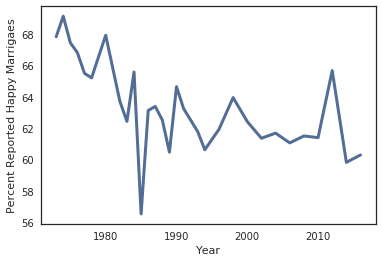

In [10]:
grouped = gss.groupby('year') #group respondents by year to calculate each year's mean

year = []
mean_hap = []

for name, group in grouped['mod_hapmar']:
    year.append(name)
    mean_hap.append(group.mean()*100)
    
thinkplot.Plot(year, mean_hap, label='label')
thinkplot.Config(xlabel='Year',
                 ylabel='Percent Reported Happy Marrigaes',
                 legend=False)

From this preliminary figure, we can see a clear downward trend over the course of the past 31 years. Let's quantify this trend with linear regression. 

LinregressResult(slope=-0.13375894677386577, intercept=329.70640055185737, rvalue=-0.6058816164664265, pvalue=0.00038779093484480926, stderr=0.033191444928695274)


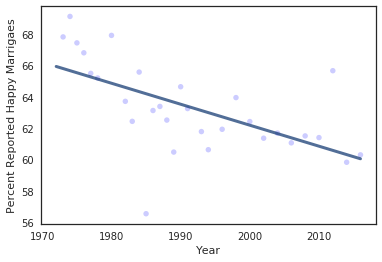

In [11]:
res = linregress(year[1:], mean_hap[1:]) 
print(res)

fx = np.array([min(year), max(year)])
fy = res.intercept + res.slope * fx

thinkplot.Scatter(year, mean_hap)
thinkplot.Plot(fx, fy)
thinkplot.Config(xlabel='Year',
                 ylabel='Percent Reported Happy Marrigaes',
                 legend=False)

This model shows that the trend is statistically signficant, with a pvalue under 0.01. The effect size seems relatively small since the percentage of reported happy marriages decreases by 0.13% per year. This means that over the course of 31 years, reported happiness levels have decreased by 4.15%. While this effect is slow, there is a clear trend that may be explained by cohort, age, or time since marriage. 

We are going to go ahead and wrap the code above into functions for further use in this investigation. 

In [16]:
def line_plot(x_var, y_var, x_label, y_label, title=''): #strings representing columns 
    xs = []
    ys = []

    for name, group in grouped[y_var]:
        xs.append(name)
        ys.append(group.mean()*100)

    thinkplot.Plot(xs, ys, label='label')
    thinkplot.Config(xlabel=x_label,
                     ylabel=y_label,
                     title=title, 
                     legend=False)
    return xs, ys

In [80]:
def linreg_plot(xs, ys, x_label, y_label, title=''): #lists
    res = linregress(xs, ys) 
    print(res)

    fx = np.array([min(xs), max(xs)])
    fy = res.intercept + res.slope * fx

    thinkplot.Scatter(xs, ys)
    thinkplot.Plot(fx, fy)
    thinkplot.Config(xlabel=x_label,
                     ylabel=y_label,
                     title=title, 
                     legend=False)

### Age 
We will start by plotting Age against Happiness in Marriage to look for any obvious trends.

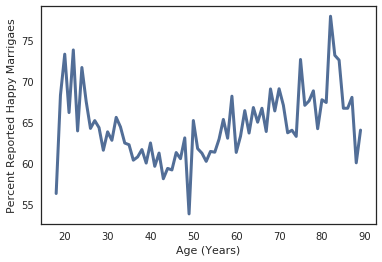

In [18]:
grouped = gss.groupby('age') #group respondents by year to calculate each year's mean
age, mean_hap = line_plot('age', 'mod_hapmar', 'Age (Years)', 'Percent Reported Happy Marrigaes')

This plot suggests a significant relationship between age and marital happiness wherein reported happiness levels decrease until early 40's and increase again from there. There is likely more noise in extreme ages due to a smaller number of respondents. A linear model does not seem fitting so we will squareroot mean_hap to attempt fitting a quadratice model to the data using linear regression. 

LinregressResult(slope=0.0031305899796761545, intercept=7.8718025531594344, rvalue=0.24896559283376554, pvalue=0.036288957731299205, stderr=0.0014661130788787065)


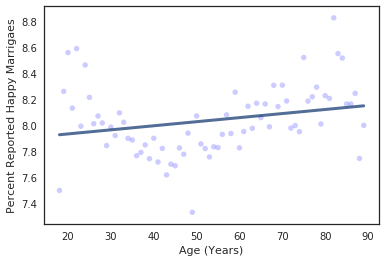

In [15]:
sqr_mean_hap = []
for i in range(len(mean_hap)):
    sqr_mean_hap.append(mean_hap[i]**.5) 
    
linreg_plot(age, sqr_mean_hap, 'Age (Years)', 'Percent Reported Happy Marrigaes')

While this trend borders on statistical significance, visually we can see that it is not the best fit to represent the data. Therefore, we will split the data into 2 subsets: respondents 42 and under, and respondents over 42. This seems like a good choice because there appears to be a linear realtion in each subset. 

LinregressResult(slope=-0.32296081645980246, intercept=73.80391681955315, rvalue=-0.5625406544328959, pvalue=0.0034204051701716915, stderr=0.09897294987370497)


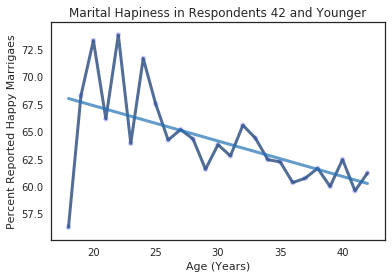

In [81]:
under_42 = gss[gss.age<=42] #respondents 42 and under

grouped = under_42.groupby('age') #group respondents by year to calculate each year's mean
age, mean_hap = line_plot('age', 'mod_hapmar', 'Age (Years)', 'Percent Reported Happy Marrigaes')
linreg_plot(age, mean_hap, 
            x_label = 'Age (Years)', 
            y_label = 'Percent Reported Happy Marrigaes', 
            title = 'Marital Hapiness in Respondents 42 and Younger')

The effect size of this trend is about -0.45%, meaning that over the course of these two decades nearly 10% fewer respondents report happy marriages. While age is the variable being tested, it is more likely that other variables tied to age cause the trend, such as birth of children and career success. 

This plot has an correlation coefficient of -0.80, indicating high predictive power. This implies that, for 20-42 year olds, age (or variables associated with age) explains most of individual's happiness levels in marriage. 

LinregressResult(slope=0.20679767219062467, intercept=51.21554097937458, rvalue=0.6513295296704045, pvalue=7.127639144839817e-07, stderr=0.03591394207629154)


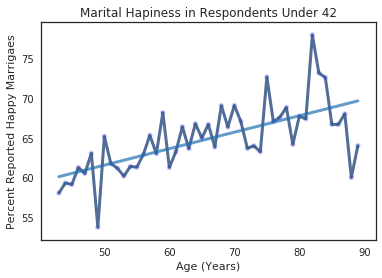

In [82]:
over_42 = gss[gss.age>42] #respondents over 42

grouped = over_42.groupby('age') #group respondents by year to calculate each year's mean
age, mean_hap = line_plot('age', 'mod_hapmar', 'Age (Years)', 'Percent Reported Happy Marrigaes')
linreg_plot(age, mean_hap, 
            x_label = 'Age (Years)', 
            y_label = 'Percent Reported Happy Marrigaes',
            title = 'Marital Hapiness in Respondents Under 42')

The upward trend past 42 has a smaller effect size of about 0.2% per year. So, over the course of 4 decades, there is an 8% increase in happiness levels compared to those at age 42. 

The rvalue of 0.63 indicates lower correlation than that of the first subset, but age still explains over half an individual's happiness in their marriage. 

### Cohort 
We will begin by looking at the overall trend of Percent Happy Marriages reported vs Year born to see if there is an obvious correlation between this variable and cohort. 

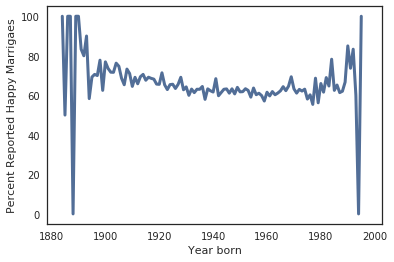

In [25]:
gss['year_born'] = gss.year - gss.age

grouped = gss.groupby('year_born') #group respondents by year to calculate each year's mean
age, mean_hap = line_plot('year_born', 'mod_hapmar', 'Year born', 'Percent Reported Happy Marrigaes')

The noise on the upper and lower bounds suggest that there is not enough data before 1900 and after 1990 to analyse these years. Therefore, we will zoom in to analyse years with more data points. 

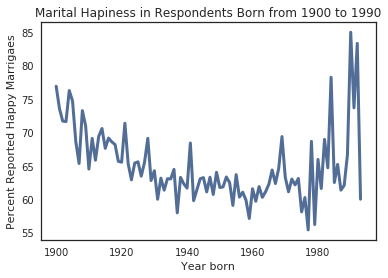

In [43]:
xs = []
ys = []

for name, group in grouped['mod_hapmar']:
    xs.append(name)
    ys.append(group.mean()*100)
    
xs = xs[17:111]
ys = ys[17:111]

thinkplot.Plot(xs, ys, label='label')
thinkplot.Config(xlabel='Year born',
                 ylabel='Percent Reported Happy Marrigaes',
                 title='Marital Hapiness in Respondents Born from 1900 to 1990', 
                 legend=False)

There appears to be a trend where, prior to about 1960, hapiness in marriage has a heavy negative correlation to birth year. However, after 1960, the trend seems to change to a much weaker positive correlation. We will attempt to fit a quadratic model to this graph to see if it is a good representation of the data.

This linear fit is statistically significant with a slope of -.044 percentage points per year. However, visually we can see that this is not the ideal fit. Let's try quadratice. 

LinregressResult(slope=-0.0028512433374063705, intercept=13.604104918618994, rvalue=-0.23984189653925536, pvalue=0.02058136646413555, stderr=0.0012098280691282203)


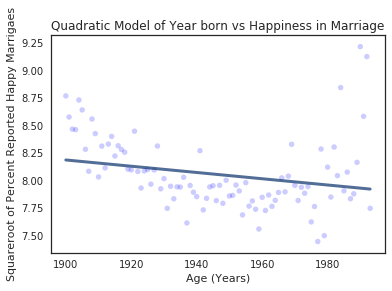

In [58]:
sqr_mean_hap = []
for i in range(len(ys)):
    sqr_mean_hap.append(ys[i]**.5) 
    
linreg_plot(xs, sqr_mean_hap, 
            x_label = 'Age (Years)', 
            y_label = 'Squareroot of Percent Reported Happy Marrigaes', 
            title = 'Quadratic Model of Year born vs Happiness in Marriage')

Again, we see that the quadratic fit boarders on being statistically significant, indicating an overall downward trend, but it fails to encompass the upward trend beyond 1960. So, we will again split the data into two subsets: respondenst born in or before 1960 and respondents born after 1960. 

LinregressResult(slope=-0.24649144507827114, intercept=541.188304896015, rvalue=-0.42416629882973916, pvalue=0.00012087219125707732, stderr=0.06076646199731933)


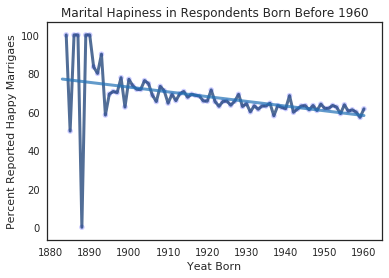

In [78]:
before_1960 = gss[gss.year_born<=1960] #respondents born before or during 1960

grouped = before_1960.groupby('year_born') #group respondents by year to calculate each year's mean
cohort, mean_hap = line_plot('age', 'mod_hapmar', 'Year Born', 'Percent Reported Happy Marrigaes')
linreg_plot(cohort, mean_hap, 
            x_label = 'Yeat Born', 
            y_label = 'Percent Reported Happy Marrigaes', 
            title = 'Marital Hapiness in Respondents Born Before 1960')

This plot shows a statisticall significant correlation with an effect size of -0.25% per year. This means that, according to this model, average percentage of reported happy marriages has dropped about 15% over the course of 60 years of cohorts. Like many of the previous models, the effect size is small from year to year, but the sustained trend causes a noteable difference over the decades. 

LinregressResult(slope=0.32107400536591735, intercept=-570.0193127653243, rvalue=0.44207558175729944, pvalue=0.011299387979512921, stderr=0.1189404802054106)


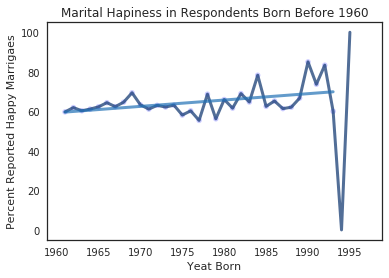

In [79]:
after_1960 = gss[gss.year_born>1960] #respondents born before or during 1960

grouped = after_1960.groupby('year_born') #group respondents by year to calculate each year's mean
cohort, mean_hap = line_plot('age', 'mod_hapmar', 'Year Born', 'Percent Reported Happy Marrigaes')
linreg_plot(cohort[:-5], mean_hap[:-5], #excludes noise form small number of respondents
            x_label = 'Yeat Born', 
            y_label = 'Percent Reported Happy Marrigaes', 
            title = 'Marital Hapiness in Respondents Born Before 1960')

Finally, we have a statistically significant upward trend for those born after 1960. The effect size is larger at 0.32% per year. From 1960 to 1990 (30 years), there is an increase of about 10%. 

The rvalues of both segments are around 0.4, suggesting that cohort is not the majority, but is a significant factor reported happiness levels. 

## Summary
We can see noteable trends in all three variables: time, cohort, and age. Based upon correlation coefficients of each, it appears that time (rvalue=0.67) has the largest effect on happiness in marriage, followed by age (avg r_value=0.60) and then cohort (avg rvalue=0.43). 

Time has a steady, negative correlation, although the effect size is small compared to the other variables at -0.14% per year. I found this interesting because so many variables surrounding marriage have changed in the past several decades, including legalization of gay marriage and increases in divorces (which should theoretically increase the rate of happiness of those that are married). Accordingly, I was unsure if the trend would be upwards or downwards and suprised that the trend was well explained with a linear model given all of this variation. 

Age has an interesting trend of decreasing relatively quickly at -0.32% per year until age 42 when it begins increasing at roughly 0.21% per year. This makes intuitive sense given the lifecycle of relationships and phases of life outside of marriage. 

Cohort has a steady decline of -0.24% per year until 1960, when the trend switched and began increasing by 0.32% per year. This suggests a trend in generational attitudes towards how marriages should be and what makes a marriage happy. It seems plausible that the factors I metioned such as legalization of gay marriage that did not impact time showed up in cohort. 